# Label Propagation

### 1. Problem Setting

Label Propagation is a **semi-supervised learning** algorithm designed for **graph-structured data**.

In many real-world problems, we have:

- A large number of data points
    
- Only a small subset of them are labeled
    
- An inherent similarity structure between samples (e.g., networks, distances, affinities)
    

Label Propagation leverages this structure by **propagating labels from labeled nodes to unlabeled nodes through the graph**.

Typical applications include:

- Social network classification
    
- Community detection
    
- Document and citation networks
    
- Biological networks
    

---

### 2. Graph Representation

The dataset is modeled as a weighted graph:

$$\large G = (V, E)$$

where:

- $\large V = \{1, 2, \dots, n\}$ is the set of nodes (samples)
    
- $\large E$ is the set of edges representing similarity
    
- $\large W \in \mathbb{R}^{n \times n}$ is the **weight (similarity) matrix**
    

Each entry:

$$\large W_{ij} \ge 0$$

measures how similar node $\large i$ is to node $\large j$.

Common constructions of $\large W$:

- k-nearest neighbors (k-NN) graph
    
- Fully connected graph with Gaussian kernel:
    

$$\large W_{ij} = \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right)$$

---

### 3. Label Representation

Assume there are $\large C$ classes.

We define a **label matrix**:

$$\large Y \in \mathbb{R}^{n \times C}$$

- For labeled nodes:  
    $\large Y_{ic} = 1$ if node iii belongs to class ccc, otherwise 0
    
- For unlabeled nodes:  
    All entries are initialized to 0
    

During training, labels are **soft values** rather than hard assignments.

---

### 4. Core Idea: Smoothness Assumption

Label Propagation relies on the **smoothness assumption**:

> **Nearby or similar nodes are likely to share the same label.**

Thus, labels should vary smoothly over the graph structure.

The algorithm iteratively updates labels by **averaging labels from neighboring nodes**, weighted by similarity.

---

### 5. Normalized Propagation Rule

First, normalize the similarity matrix:

$$\large D_{ii} = \sum_j W_{ij}$$​ $$\large S = D^{-1} W$$

where:

- $\large D$ is the degree matrix
    
- $\large S$ is the row-normalized similarity matrix
    

The label update rule is:

$$\large Y^{(t+1)} = S Y^{(t)}$$

This operation diffuses label information across the graph.

---

### 6. Clamping (Preserving Known Labels)

To prevent labeled nodes from drifting, we **clamp** their labels at every iteration:

$$\large Y^{(t+1)}_L = Y_L$$

where:

- $\large L$ denotes labeled nodes
    

This ensures that known labels remain fixed and act as **sources of information**.

---

### 7. Convergence

The algorithm iterates until:

- Label matrix converges (change below tolerance), or
    
- A maximum number of iterations is reached
    

At convergence, each node has a **soft label distribution** over classes.

Final prediction:

$$\large \hat{y}_i = \arg\max_c Y_{ic}$$

---

### 8. Key Characteristics

**Advantages**

- Naturally handles unlabeled data
    
- Simple and intuitive
    
- No explicit model training
    
- Works well when graph structure is informative
    

**Limitations**

- Sensitive to graph construction
    
- Poor performance if similarity graph is noisy
    
- Scalability issues for very large graphs

## Data Loading

In this example, we use a human activity recognition dataset obtained from Kaggle.
The dataset consists of time-series features extracted from wearable sensor data,
with each sample labeled by the type of human activity being performed.

This dataset is well-suited for demonstrating **label propagation**, as activity
labels are often expensive to obtain in practice, while large amounts of unlabeled
sensor data are readily available.

We load the dataset from a CSV file and separate features from activity labels.


In [25]:
import pandas as pd
import numpy as np

# Load dataset (use relative path for portability)
df = pd.read_csv("D:/研究生/机器学习/INDE-577/ml_project/examples/data/time_series_data_human_activities.csv")

df.head()

df.shape, df.columns


((1073623, 6),
 Index(['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis'], dtype='object'))

## Feature Selection and Preprocessing

The dataset includes both feature columns and non-feature columns.
We remove user identifiers and timestamps, retaining only the sensor
measurements as input features.

Since label propagation relies on distance-based similarities, we
standardize the feature values before constructing the similarity graph.


In [26]:
from sklearn.preprocessing import StandardScaler

# Non-feature columns
non_feature_cols = ["user", "activity", "timestamp"]

# Feature matrix and labels
X = df.drop(columns=non_feature_cols).values
y_true = df["activity"].values

print("Feature matrix shape:", X.shape)
print("Label vector shape:", y_true.shape)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sanity check
X_scaled.mean(axis=0), X_scaled.std(axis=0)



Feature matrix shape: (1073623, 3)
Label vector shape: (1073623,)


(array([ 4.31769886e-17, -2.20279413e-16,  2.30312570e-18]),
 array([1., 1., 1.]))

## Subsampling

Graph-based label propagation has quadratic memory and computational
complexity with respect to the number of samples.

To keep this example computationally feasible while preserving the
underlying data structure, we randomly subsample a subset of the data.


In [27]:
rng = np.random.RandomState(42)

n_samples = 3000  # example-scale subset
indices = rng.choice(len(X_scaled), size=n_samples, replace=False)

X_sub = X_scaled[indices]
y_true_sub = y_true[indices]

print("Subsampled shape:", X_sub.shape)


Subsampled shape: (3000, 3)


## Semi-Supervised Setting

We simulate a semi-supervised learning scenario by masking most of the
activity labels. Only a small fraction of samples are assumed to be labeled.

Unlabeled samples are assigned a label value of -1.


In [28]:
# Keep only 15% labeled samples
mask = rng.rand(len(y_true_sub)) < 0.15

y_semi = np.full_like(y_true_sub, fill_value=-1, dtype=object)
y_semi[mask] = y_true_sub[mask]

# Check label distribution (SAFE)
pd.Series(y_semi).value_counts()


-1            2552
Walking        171
Jogging        132
Upstairs        47
Downstairs      39
Sitting         35
Standing        24
Name: count, dtype: int64

## Label Propagation

We now apply the label propagation algorithm implemented in the
`rice_ml` package to infer labels for the unlabeled samples.


In [29]:
from rice_ml.label_propagation import LabelPropagation

lp = LabelPropagation(gamma=1.0, max_iter=100)

y_pred = lp.fit_predict(X_sub, y_semi)

# Predicted label distribution
pd.Series(y_pred).value_counts()


Walking       2636
Jogging        213
Upstairs        47
Sitting         41
Downstairs      39
Standing        24
Name: count, dtype: int64

## Visualization

To visualize the results, we project the data into two dimensions using
Principal Component Analysis (PCA).


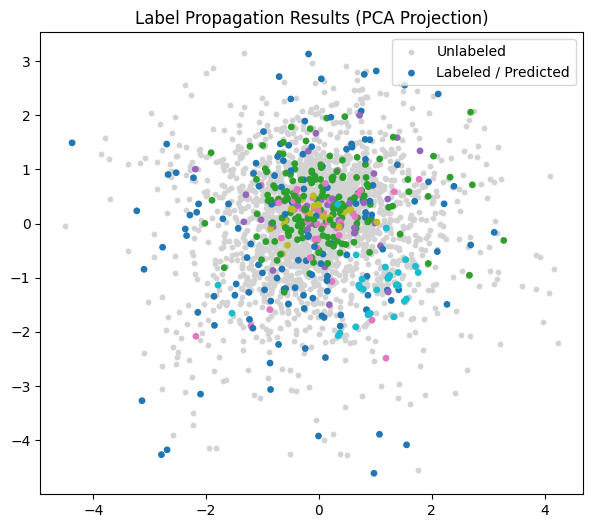

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_sub)

plt.figure(figsize=(7, 6))

unlabeled_mask = y_semi == -1

plt.scatter(
    X_2d[unlabeled_mask, 0],
    X_2d[unlabeled_mask, 1],
    c="lightgray",
    s=10,
    label="Unlabeled"
)

plt.scatter(
    X_2d[~unlabeled_mask, 0],
    X_2d[~unlabeled_mask, 1],
    c=pd.factorize(y_pred[~unlabeled_mask])[0],
    cmap="tab10",
    s=15,
    label="Labeled / Predicted"
)

plt.title("Label Propagation Results (PCA Projection)")
plt.legend()
plt.show()


## Summary

In this example, we demonstrated how label propagation can leverage a small
set of labeled sensor measurements to infer activity labels for a large
set of unlabeled data.

By constructing a similarity graph and propagating label information,
the algorithm effectively exploits the underlying structure of the data.
